##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction to graphs and `tf.function`

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/intro_to_graphs"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/intro_to_graphs.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/intro_to_graphs.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/intro_to_graphs.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This guide goes beneath the surface of TensorFlow and Keras to demonstrate how TensorFlow works. If you instead want to immediately get started with Keras, check out the [collection of Keras guides](https://www.tensorflow.org/guide/keras/).

In this guide, you'll learn how TensorFlow allows you to make simple changes to your code to get graphs, how graphs are stored and represented, and how you can use them to accelerate your models.

Note: For those of you who are only familiar with TensorFlow 1.x, this guide demonstrates a very different view of graphs.

**This is a big-picture overview that covers how `tf.function` allows you to switch from eager execution to graph execution.** For a more complete specification of `tf.function`, go to the [Better performance with `tf.function`](./function.ipynb) guide.


이 가이드는 TensorFlow의 구동 방식을 보여주기 위해 TensorFlow 및 Keras의 표면 아래로 이동합니다. 대신 Keras를 즉시 시작하려면 Keras 가이드 모음을 확인하십시오.

이 가이드에서는 TensorFlow를 사용하여 코드를 간단하게 변경하여 `graph`를 얻는 방법, 그래프를 저장하고 표현하는 방법, 그리고 이를 사용하여 모델을 가속화하는 방법을 배웁니다.

참고: TensorFlow 1.x에만 익숙한 사용자를 위해 이 가이드는 매우 다른 그래프 보기를 보여줍니다.

이것은 `tf.function`을 사용하여 `eager` 실행에서 `graph` 실행으로 전환하는 방법을 다루는 큰 그림 개요입니다. `tf.function`에 대한 보다 완전한 사양을 보려면 `tf.function으로 성능 향상 가이드`로 이동하십시오.

### What are graphs?

In the previous three guides, you ran TensorFlow **eagerly**. <font color="red">This means TensorFlow operations are executed by Python, operation by operation, and returning results back to Python.[**eager mode 정의**]</font>

While eager execution has several unique advantages, graph execution enables portability outside Python and tends to offer better performance. **Graph execution** means that tensor computations are executed as a *TensorFlow graph*, sometimes referred to as a `tf.Graph` or simply a "graph."

**Graphs are data structures that contain a set of `tf.Operation` objects, which represent units of computation; and `tf.Tensor` objects, which represent the units of data that flow between operations.** They are defined in a `tf.Graph` context. Since these graphs are data structures, they can be saved, run, and restored all without the original Python code.

This is what a TensorFlow graph representing a two-layer neural network looks like when visualized in TensorBoard:

이전 세 가이드에서는 TensorFlow를 `eagerly` 실행했습니다. 즉, TensorFlow 작업은 Python VM에 의해 실행되고 ops별로 실행되고 결과를 Python VM으로 다시 반환합니다.[eager mode 정의]

`eager` 실행에는 몇 가지 고유한 장점이 있지만 `graph` 실행은 Python 외부에서 이식성을 가능하게 하고 더 나은 성능을 제공하는 경향이 있습니다. `graph` 실행은 텐서 계산이 tf.Graph 또는 단순히 "그래프"라고도 하는 TensorFlow `graph`로 실행됨을 의미합니다.

`graph`는 계산 단위를 나타내는 tf.Operation 개체 집합을 포함하는 데이터 구조입니다. 작업 간에 흐르는 데이터 단위를 나타내는 tf.Tensor 객체. tf.Graph 컨텍스트에서 정의됩니다. **이 `graph`는 데이터 구조이기 때문에 원본 Python 코드 없이 모두 저장, 실행 및 복원할 수 있습니다.**

다음은 2계층 신경망을 TensorBoard에서 시각화한 TensorFlow `graph`의 모습입니다.

<img alt="A simple TensorFlow graph" src="https://github.com/tensorflow/docs/blob/master/site/en/guide/images/intro_to_graphs/two-layer-network.png?raw=1">

### The benefits of graphs

With a graph, you have a great deal of flexibility.  You can use your TensorFlow graph in environments that don't have a Python interpreter, like mobile applications, embedded devices, and backend servers. TensorFlow uses graphs as the format for [saved models](./saved_model.ipynb) when it exports them from Python.

Graphs are also easily optimized, allowing the compiler to do transformations like:

* Statically infer the value of tensors by folding constant nodes in your computation *("[constant folding](https://en.wikipedia.org/wiki/Constant_folding):컴파일러 최적화")*.
* Separate sub-parts of a computation that are independent and split them between threads or devices.
* Simplify arithmetic operations by eliminating common subexpressions.


그래프를 사용하면 상당한 유연성을 갖게 됩니다. 모바일 애플리케이션, 임베디드 기기, 백엔드 서버와 같이 Python VM가 없는 환경에서 TensorFlow 그래프를 사용할 수 있습니다. Python에서 TensorFlow를 export할 때 saved model의 형식으로 그래프를 사용합니다.

그래프는 또한 쉽게 최적화되어 컴파일러에서 다음과 같은 변환을 수행할 수 있습니다.

* 연산에서 상수 노드를 폴딩함으로써 텐서의 값을 정적으로 유추합니다.
* 독립적인 연산의 하위 부분을 분리하고 이를 스레드 또는 장치 간에 분할합니다.
* 일반적인 하위 표현식을 제거하여 산술 연산을 단순화합니다.

There is an entire optimization system, [Grappler](./graph_optimization.ipynb), to perform this and other speedups.

In short, graphs are extremely useful and let your TensorFlow run **fast**, run **in parallel**, and run efficiently **on multiple devices**.

However, you still want to define your machine learning models (or other computations) in Python for convenience, and then automatically construct graphs when you need them.

위 작업들과 다른 속도 향상을 수행하기 위한 전체 최적화 시스템인 `Grappler`가 있습니다.

요컨대, 그래프는 매우 유용하며 TensorFlow를 빠르게 실행하고 병렬로 실행하며 여러 장치에서 효율적으로 실행할 수 있습니다.

그러나 편의를 위해 Python에서 머신러닝 모델(또는 기타 계산)을 정의한 다음 필요할 때 자동으로 그래프를 구성하려고 합니다.

## Setup

Import some necessary libraries:

In [1]:
import tensorflow as tf
import timeit
from datetime import datetime

## Taking advantage of graphs

You create and run a graph in TensorFlow by using `tf.function`, either as a direct call or as a decorator. `tf.function` takes a regular function as input and returns a `Function`. **A `Function` is a Python callable that builds TensorFlow graphs from the Python function. You use a `Function` in the same way as its Python equivalent.**


직접 호출[`tf.function()`]이나 데코레이터[@tf.function]를 사용하여 TensorFlow에서 그래프를 만들고 실행합니다. `tf.function`은 일반 함수를 입력으로 받아 `Function`를 반환합니다. <font color="blue"><b>`Function`는 Python 함수[<font color="red">데코레이터의 타겟 또는 tf.function 함수의 인자로 전달된</font>]에서 TensorFlow 그래프를 빌드하는 Python `callable`입니다. Python과 동일한 방식으로 `Function`을 사용합니다.</b></font>

In [2]:
# Define a Python function.
def a_regular_function(x, y, b):
  x = tf.matmul(x, y)
  x = x + b
  return x

# `a_function_that_uses_a_graph` is a TensorFlow `Function`
# a_function_that_uses_a_graph는 "TensorFlow 그래프를 빌드하는 Python callable."
a_function_that_uses_a_graph = tf.function(a_regular_function)
print("a_function_that_uses_a_graph is : ", a_function_that_uses_a_graph)

# Make some tensors.
x1 = tf.constant([[1.0, 2.0]])
y1 = tf.constant([[2.0], [3.0]])
b1 = tf.constant(4.0)

orig_value = a_regular_function(x1, y1, b1).numpy()

# Call a `Function` like a Python function.
tf_function_value = a_function_that_uses_a_graph(x1, y1, b1).numpy()

# assert(orig_value == tf_function_value)
print("orig_value=", orig_value)
print("tf_function_value=", tf_function_value)

a_function_that_uses_a_graph is :  <tensorflow.python.eager.def_function.Function object at 0x7fe9e0447730>
orig_value= [[12.]]
tf_function_value= [[12.]]


On the outside, a `Function` looks like a regular function you write using TensorFlow operations. [Underneath](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/eager/def_function.py), however, it is *very different*. A `Function` **encapsulates several `tf.Graph`s behind one API** (learn more in the _Polymorphism_ section). That is how a `Function` is able to give you the benefits of graph execution, like speed and deployability (refer to _The benefits of graphs_ above).

외부에서 `Function`는 TensorFlow ops을 사용하여 작성하는 일반 함수처럼 보입니다. 그러나 그 아래에는 매우 다릅니다. `Function`는 하나의 API 뒤에 여러 tf.Graphs를 캡슐화합니다(다형성 섹션에서 자세히 알아보기). 이것이 바로 `Function`이 속도 및 배포 가능성과 같은 그래프 실행의 이점을 제공할 수 있는 방법입니다(위 그래프의 이점 참조).

`tf.function` applies to a function *and all other functions it calls*:

tf.function이 적용된 함수가,</br> 호출하는 다른 모든 함수에도 tf.function이 적용됩니다.

In [3]:
def inner_function(x, y, b):
  x = tf.matmul(x, y)
  x = x + b
  return x

# Use the decorator to make `outer_function` a `Function`.
@tf.function
def outer_function(x):
  y = tf.constant([[2.0], [3.0]])
  b = tf.constant(4.0)

  return inner_function(x, y, b)

In [4]:
# Note that the callable will create a graph that
# includes `inner_function` as well as `outer_function`.
outer_function(tf.constant([[1.0, 2.0]])).numpy()

array([[12.]], dtype=float32)

If you have used TensorFlow 1.x, you will notice that at no time did you need to define a `Placeholder` or `tf.Session`.

software version
Major.Minor.Micro

### Converting Python functions to graphs

Any function you write with TensorFlow will contain a mixture of built-in TF operations and Python logic, such as `if-then` clauses, loops, `break`, `return`, `continue`, and more. While TensorFlow operations are easily captured by a `tf.Graph`, Python-specific logic needs to undergo an extra step in order to become part of the graph. `tf.function` uses a library called AutoGraph (`tf.autograph`) to convert Python code into graph-generating code.


TensorFlow로 작성하는 모든 함수에는 `if-then` 절, `loop`, `break`, `return`, `continue` 등과 같은 Python 로직과 내장 TF ops와  혼합되어 있습니다. TensorFlow ops은 tf.Graph로 쉽게 캡처되지만 Python 관련 로직은 그래프의 일부가 되려면 추가 단계를 거쳐야 합니다. `tf.function`은 `AutoGraph(tf.autograph)`라는 라이브러리를 사용하여 Python 코드를 graph-generating code로 변환합니다.

In [5]:
def simple_relu(x):
  if tf.greater(x, 0):
    return x
  else:
    return 0

# `tf_simple_relu` is a TensorFlow `Function` that wraps `simple_relu`.
tf_simple_relu = tf.function(simple_relu)

In [6]:
print("First branch, with graph:", tf_simple_relu(tf.constant(1)).numpy())
print("Second branch, with graph:", tf_simple_relu(tf.constant(-1)).numpy())

First branch, with graph: 1
Second branch, with graph: 0


Though it is unlikely that you will need to view graphs directly, you can inspect the outputs to check the exact results. These are not easy to read, so no need to look too carefully!

그래프를 직접 볼 필요는 없지만 출력을 검사하여 정확한 결과를 확인할 수 있습니다. 이것들은 읽기 쉽지 않으므로 너무 주의 깊게 볼 필요는 없습니다!

In [ ]:
# This is the graph-generating output of AutoGraph.
print(tf.autograph.to_code(simple_relu))

In [ ]:
# This is the graph itself.
print(tf_simple_relu.get_concrete_function(tf.constant(1)).graph.as_graph_def())

Most of the time, `tf.function` will work without  special considerations. However, there are some caveats, and the [`tf.function` guide](./function.ipynb) can help here, as well as the [complete AutoGraph reference](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/index.md).

대부분의 경우 tf.function은 특별한 고려 없이 작동합니다. 그러나 몇 가지 주의 사항이 있으며 tf.function 가이드와 완전한 AutoGraph 참조가 여기에 도움이 될 수 있습니다.

### Polymorphism: one `Function`, many graphs

A `tf.Graph` is specialized to a specific type of inputs (for example, tensors with a specific [`dtype`](https://www.tensorflow.org/api_docs/python/tf/dtypes/DType) or objects with the same [`id()`](https://docs.python.org/3/library/functions.html#id])).

Each time you invoke a `Function` with a set of arguments that can't be handled by any of its existing graphs (such as arguments with new `dtypes` or incompatible shapes), `Function` creates a new `tf.Graph` specialized to those new arguments. The type specification of a `tf.Graph`'s inputs is known as its **input signature** or just a **signature**. For more information regarding when a new `tf.Graph` is generated and how that can be controlled, go to the _Rules of tracing_ section of the [Better performance with `tf.function`](./function.ipynb) guide.

The `Function` stores the `tf.Graph` corresponding to that signature in a `ConcreteFunction`. **A `ConcreteFunction` is a wrapper around a `tf.Graph`.**


tf.Graph는 특정 유형의 입력에 특화되어 있습니다(예: 특정 dtype을 가진 텐서 또는 동일한 id()를 가진 객체).

기존 그래프에서 처리할 수 없는 인수 집합(예: 새로운 dtypes 또는 호환되지 않는 shape이 있는 인수)으로 함수를 호출할 때마다 함수는 해당 새로운 인수에 특화된 새로운 tf.Graph를 만듭니다.

In [11]:
def my_relu_p(x):
  # print("called my_relu")
  return tf.maximum(0., x)

In [12]:
print(type(my_relu_p)) # python에서 함수는 function 클래스임!!!

<class 'function'>


In [2]:
@tf.function
def my_relu(x):
  print("called my_relu")
  return tf.maximum(0., x)

In [15]:
print(type(my_relu)) # tensorflow.python.eager.def_function.Function 클래스임!!!

<class 'tensorflow.python.eager.def_function.Function'>


https://android.googlesource.com/platform/external/tensorflow/+/632ff3f6169ef18a6947c53bd6f3cb5bf7fc26a6/tensorflow/python/eager/def_function.py

In [3]:
# `my_relu` creates new graphs as it observes more signatures.

print(my_relu(tf.constant(5.5)))  # argument는 
                                  # 스칼라인 Tensor, 시그너쳐

called my_relu
tf.Tensor(5.5, shape=(), dtype=float32)


In [4]:
print(my_relu(tf.constant(6.0)))                                 

tf.Tensor(6.0, shape=(), dtype=float32)


그래프 Function의 signature가 Tensor가 아니라면,
즉, 파이썬 데이터 타입이라면, 새로운 시그너쳐가 계속 만들어진다.

In [5]:
print(my_relu([1, -1])) # argument는,
                        # element가 정수인 파이썬 list, 시그너쳐

called my_relu
tf.Tensor([1. 0.], shape=(2,), dtype=float32)


In [6]:
print(my_relu([3, -7])) # argument는,
                        # element가 정수인 파이썬 list, 시그너쳐

called my_relu
tf.Tensor([3. 0.], shape=(2,), dtype=float32)


In [7]:
print(my_relu(tf.constant([3., -3.]))) # argument는 
                                       # element가 실수인 Tensor, 시그너쳐

called my_relu
tf.Tensor([3. 0.], shape=(2,), dtype=float32)


If the `Function` has already been called with that signature, `Function` does not create a new `tf.Graph`.

함수가 이미 해당 signature으로 호출된 경우 함수는 새로운 tf.Graph를 생성하지 않습니다.

In [8]:
# These two calls do *not* create new graphs.
print(my_relu(tf.constant(-2.5))) # Signature matches `tf.constant(5.5)`.


tf.Tensor(0.0, shape=(), dtype=float32)


In [9]:
print(my_relu(tf.constant([-1., 1.]))) # Signature matches `tf.constant([3., -3.])`.

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


Because it's backed by multiple graphs, a `Function` is **polymorphic**. That enables it to support more input types than a single `tf.Graph` could represent, and to optimize each `tf.Graph` for better performance.

여러개의 그래프가 지원되기 때문에 `Function`는 다형성입니다. 이를 통해 단일 tf.Graph가 표현할 수 있는 것보다 더 많은 입력 유형[signature]을 지원하고 더 나은 성능을 위해 각 tf.Graph를 최적화할 수 있습니다.

In [10]:
# There are three `ConcreteFunction`s (one for each graph) in `my_relu`.
# The `ConcreteFunction` also knows the return type and shape!
print(my_relu.pretty_printed_concrete_signatures())

my_relu(x)
  Args:
    x: float32 Tensor, shape=()
  Returns:
    float32 Tensor, shape=()

my_relu(x=[1, -1])
  Returns:
    float32 Tensor, shape=(2,)

my_relu(x=[3, -7])
  Returns:
    float32 Tensor, shape=(2,)

my_relu(x)
  Args:
    x: float32 Tensor, shape=(2,)
  Returns:
    float32 Tensor, shape=(2,)


## Using `tf.function`

So far, you've learned how to convert a Python function into a graph simply by using `tf.function` as a decorator or wrapper. But in practice, getting `tf.function` to work correctly can be tricky! In the following sections, you'll learn how you can make your code work as expected with `tf.function`.

지금까지 `tf.function`을 데코레이터 또는 래퍼로 사용하여 Python 함수를 그래프로 변환하는 방법을 배웠습니다. 그러나 실제로는 `tf.function`이 올바르게 작동하도록 하는 것이 까다로울 수 있습니다! 다음 섹션에서는 `tf.function`을 사용하여 코드가 예상대로 작동하도록 하는 방법을 배웁니다.

### Graph execution vs. eager execution

The code in a `Function` can be executed both eagerly and as a graph. By default, `Function` executes its code as a graph:


`Function`의 코드는 `eagerly` 실행될 수도 있고 `graph`로 실행될 수도 있습니다. 기본적으로 `Function`은 코드를 그래프로 실행합니다.

In [11]:
@tf.function
def get_MSE(y_true, y_pred):
  print("called get_MSE")
  sq_diff = tf.pow(y_true - y_pred, 2)
  return tf.reduce_mean(sq_diff)

In [12]:
y_true = tf.random.uniform([5], maxval=10, dtype=tf.int32)
y_pred = tf.random.uniform([5], maxval=10, dtype=tf.int32)
print(y_true)
print(y_pred)

tf.Tensor([5 7 0 3 5], shape=(5,), dtype=int32)
tf.Tensor([6 7 5 5 9], shape=(5,), dtype=int32)


In [13]:
get_MSE(y_true, y_pred)

called get_MSE


<tf.Tensor: shape=(), dtype=int32, numpy=9>

To verify that your `Function`'s graph is doing the same computation as its equivalent Python function, you can make it execute eagerly with `tf.config.run_functions_eagerly(True)`. This is a switch that **turns off `Function`'s ability to create and run graphs**, instead of executing the code normally.

`Function`의 그래프가 원래의 Python 함수와 동일한 계산을 수행하는지 확인하려면 `tf.config.run_functions_eagerly(True)`를 사용하여 빠르게 실행되도록 할 수 있습니다. 이것은 코드를 정상적으로 실행하는 대신 `graph`를 생성하고 실행하는 `Function`의 기능을 끄는 스위치입니다.

In [14]:
tf.config.run_functions_eagerly(True)

In [15]:
get_MSE(y_true, y_pred)

called get_MSE


<tf.Tensor: shape=(), dtype=int32, numpy=9>

In [16]:
get_MSE(y_true, y_pred)

called get_MSE


<tf.Tensor: shape=(), dtype=int32, numpy=9>

In [17]:
# Don't forget to set it back when you are done.
tf.config.run_functions_eagerly(False)

In [18]:
get_MSE(y_true, y_pred)

<tf.Tensor: shape=(), dtype=int32, numpy=9>

However, `Function` can behave differently under graph and eager execution. The Python [`print`](https://docs.python.org/3/library/functions.html#print) function is one example of how these two modes differ. Let's check out what happens when you insert a `print` statement to your function and call it repeatedly.

그러나 `Function`은 `graph`와 `eager` 실행에서 다르게 동작할 수 있습니다. Python의 print함수는 이 두 모드가 어떻게 다른지 보여주는 한 가지 예입니다. 함수에 print 문을 삽입하고 반복적으로 호출하면 어떻게 되는지 확인해 봅시다.

In [22]:
@tf.function
def get_MSE(y_true, y_pred):
  print("Calculating MSE!") ##############
  # tf.print("Calculating MSE!")
  sq_diff = tf.pow(y_true - y_pred, 2)
  return tf.reduce_mean(sq_diff)

Observe what is printed:

In [23]:
error = get_MSE(y_true, y_pred)

Calculating MSE!


In [24]:
error = get_MSE(y_true, y_pred)
error = get_MSE(y_true, y_pred)

In [ ]:
@tf.function
def get_MSE(y_true, y_pred):
  # print("Calculating MSE!") ##############
  tf.print("Calculating MSE!")
  sq_diff = tf.pow(y_true - y_pred, 2)
  return tf.reduce_mean(sq_diff)

In [ ]:
error = get_MSE(y_true, y_pred)
error = get_MSE(y_true, y_pred)
error = get_MSE(y_true, y_pred)

Calculating MSE!
Calculating MSE!
Calculating MSE!


Is the output surprising? **`get_MSE` only printed once even though it was called *three* times.**

To explain, the `print` statement is executed when `Function` runs the original code in order to create the graph in a process known as "tracing" (refer to the _Tracing_ section of the [`tf.function` guide](./function.ipynb). **Tracing captures the TensorFlow operations into a graph, and `print` is not captured in the graph.**  That graph is then executed for all three calls **without ever running the Python code again**.

As a sanity check, let's turn off graph execution to compare:

출력이 놀랍습니까? get_MSE는 세 번 호출되었지만 한 번만 print함수의 스트링이 콘솔에 출력 되었습니다.

설명하자면, print 문은 "tracing"으로 알려진 프로세스에서 그래프를 생성하기 위해 `Function`이 원본 코드를 실행할 때 실행됩니다(tf.function 가이드의 Tracing 섹션 참조). Tracing은 TensorFlow ops을 그래프로 캡처하고, 그리고 print함수는 그래프에 캡처되지 않습니다. 그런 다음 해당 그래프는 Python 코드를 다시 실행하지 않고 세 호출 모두에 대해 실행됩니다.

온전한 확인을 위해 그래프 실행을 꺼서 비교하겠습니다.

In [25]:
# Now, globally set everything to run eagerly to force eager execution.
tf.config.run_functions_eagerly(True)

In [26]:
# Observe what is printed below.
error = get_MSE(y_true, y_pred)
error = get_MSE(y_true, y_pred)
error = get_MSE(y_true, y_pred)

Calculating MSE!
Calculating MSE!
Calculating MSE!


eager 모드에서 실행된 것은 get_MSE의 Function인가???

In [27]:
print(type(get_MSE))

<class 'tensorflow.python.eager.def_function.Function'>


In [28]:
tf.config.run_functions_eagerly(False)

`print` is a *Python side effect*, and there are other differences that you should be aware of when converting a function into a `Function`. Learn more in the _Limitations_ section of the [Better performance with `tf.function`](./function.ipynb) guide.

`print`는 파이썬의 부작용이며, 파이썬 함수를 `Function`로 변환할 때 알아야 할 다른 차이점이 있습니다. tf.function으로 성능 향상 가이드의 제한 사항 섹션에서 자세히 알아보세요.

Note: If you would like to print values in both eager and graph execution, use `tf.print` instead.

### Non-strict execution

<a id="non-strict"></a>

Graph execution only executes the operations necessary to produce the observable effects, which includes:

- The return value of the function
- Documented well-known side-effects such as:
  - Input/output operations, like `tf.print`
  - Debugging operations, such as the assert functions in `tf.debugging`
  - Mutations of `tf.Variable`

This behavior is usually known as "Non-strict execution", and differs from eager execution, which steps through all of the program operations, needed or not.

In particular, runtime error checking does not count as an observable effect. If an operation is skipped because it is unnecessary, it cannot raise any runtime errors.

In the following example, the "unnecessary" operation `tf.gather` is skipped during graph execution, so the runtime error `InvalidArgumentError` is not raised as it would be in eager execution. Do not rely on an error being raised while executing a graph.

그래프 실행은 다음을 포함하여 관찰 가능한 효과를 생성하는 데 필요한 ops만 실행합니다.

* 함수의 반환 값
* 다음과 같은 문서화된 잘 알려진 부작용:
  
  1. tf.print와 같은 input/output ops
  2. tf.debugging의 assert 기능과 같은 디버깅 작업
  3. tf.Variable의 Mutations

<font color="red">이것은 일반적으로 "비엄격 실행"으로 알려져 있으며, 필요하거나 필요하지 않은 모든 프로그램 ops을 단계별로 실행하는 `eager` 실행과 다릅니다.

특히 런타임 오류 검사는 관찰 가능한 효과로 계산되지 않습니다. 만약 특정 op가 불필요해서 스킵된다면, 런타임 오류가 발생할 수 없습니다.

다음 예에서는 그래프 실행 중에 "불필요한" op인 tf.gather를 스킵함으로써 `eager` 실행에서와 같이 런타임 오류 InvalidArgumentError가 발생하지 않습니다. 그래프를 실행하는 동안 발생하는 오류에 의존하지 마십시오.</font>

In [36]:
def unused_return_eager2(x):
  # Get index 1 will fail when `len(x) == 1`
  tf.gather(x, [1]) # unused 
  return x

In [37]:
try:
  print(unused_return_eager2(tf.constant([0.0])))
except tf.errors.InvalidArgumentError as e:
  # All operations are run during eager execution so an error is raised.
  print(f'{type(e).__name__}: {e}')

tf.Tensor([0.], shape=(1,), dtype=float32)


In [30]:
def unused_return_eager(x):
  # Get index 1 will fail when `len(x) == 1`
  tf.gather(x, [1]) # unused 
  return x

In [31]:
try:
  print(unused_return_eager(tf.constant([0.0])))
except tf.errors.InvalidArgumentError as e:
  # All operations are run during eager execution so an error is raised.
  print(f'{type(e).__name__}: {e}')

tf.Tensor([0.], shape=(1,), dtype=float32)


In [32]:
@tf.function
def unused_return_graph(x):
  # runtime error checking does not count as an observable effect.
  tf.gather(x, [1]) # unused
  # tf.gather(x, [0])
  return x

In [35]:
print(tf.autograph.to_code(unused_return_eager))

def tf__unused_return_eager(x):
    with ag__.FunctionScope('unused_return_eager', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        ag__.converted_call(ag__.ld(tf).gather, (ag__.ld(x), [1]), None, fscope)
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [34]:
# Only needed operations are run during graph execution. The error is not raised.
print(unused_return_graph(tf.constant([0.0])))

tf.Tensor([0.], shape=(1,), dtype=float32)


### `tf.function` best practices

It may take some time to get used to the behavior of `Function`.  To get started quickly, first-time users should play around with decorating toy functions with `@tf.function` to get experience with going from eager to graph execution.

*Designing for `tf.function`* may be your best bet for writing graph-compatible TensorFlow programs. Here are some tips:
-  Toggle between eager and graph execution early and often with `tf.config.run_functions_eagerly` to pinpoint if/ when the two modes diverge.
- Create `tf.Variable`s
outside the Python function and modify them on the inside. The same goes for objects that use `tf.Variable`, like `tf.keras.layers`, `tf.keras.Model`s and `tf.keras.optimizers`.
- Avoid writing functions that depend on outer Python variables, excluding `tf.Variable`s and Keras objects. Learn more in _Depending on Python global and free variables_ of the [`tf.function` guide](./function.ipynb).
- Prefer to write functions which take tensors and other TensorFlow types as input. You can pass in other object types but be careful! Learn more in _Depending on Python objects_ of the [`tf.function` guide](./function.ipynb).
- Include as much computation as possible under a `tf.function` to maximize the performance gain. For example, decorate a whole training step or the entire training loop.


Function의 동작에 익숙해지는 데 시간이 걸릴 수 있습니다. 빠르게 시작하려면, 처음 사용자는 @tf.function 데코레이터로 `eager`에서 `graph` 실행으로 전환하는 경험을 얻어야 합니다.

`tf.function`으로 설계하는 것은 그래프 호환 TensorFlow 프로그램을 작성하는 가장 좋은 방법일 수 있습니다. 다음은 몇 가지 팁입니다.

* tf.config.run_functions_eagerly를 사용하여 초기에 그리고 자주 `eager` 실행과 `graph` 실행 사이를 전환하여 두 모드가 분기되는 if/when를 정확히 찾아냅니다.

* Python 함수 외부에서 tf.Variables를 만들고 내부에서 수정합니다. tf.keras.layers, tf.keras.Models 및 tf.keras.optimizers와 같이 tf.Variable을 사용하는 객체도 마찬가지입니다.

* tf.Variables 및 Keras 객체를 제외하고 외부 Python 변수에 의존하는 함수를 작성하지 마십시오. tf.function 가이드의 Python 전역 및 자유 변수에 관한 부분을 확인해 보세요

*성능 이득을 최대화하려면 tf.function 아래에 가능한 한 많은 계산을 포함하십시오. 예를 들어 whole training step 또는 entire training loop를 데코레이터합니다

## Seeing the speed-up

`tf.function` usually improves the performance of your code, but the amount of speed-up depends on the kind of computation you run. Small computations can be dominated by the overhead of calling a graph. You can measure the difference in performance like so:

tf.function은 일반적으로 코드의 성능을 향상시키지만 속도 향상의 정도는 실행하고자하는 계산의 종류에 따라 다릅니다. 작은 계산은 그래프 호출의 오버헤드에 의해 좌우될 수 있습니다. 다음과 같이 성능 차이를 측정할 수 있습니다.

In [38]:
x = tf.random.uniform(shape=[10, 10], minval=-1, maxval=2, dtype=tf.dtypes.int32)

def power(x, y):  
  result = tf.eye(10, dtype=tf.dtypes.int32)
  for _ in range(y):
    result = tf.matmul(x, result)
  return result

In [39]:
print("Eager execution:", timeit.timeit(lambda: power(x, 100), number=1000))

Eager execution: 2.8689453920001142


In [40]:
power_as_graph = tf.function(power)
print("Graph execution:", timeit.timeit(lambda: power_as_graph(x, 100), number=1000))

Graph execution: 0.8131628179999097


`tf.function` is commonly used to speed up training loops, and you can learn more about it in the _Speeding-up your training step with `tf.function`_ section of the [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) with Keras guide.

Note: You can also try `tf.function(jit_compile=True)` for a more significant performance boost, especially if your code is heavy on TensorFlow control flow and uses many small tensors. Learn more in the _Explicit compilation with `tf.function(jit_compile=True)`_ section of the [XLA overview](https://www.tensorflow.org/xla).

### Performance and trade-offs

Graphs can speed up your code, but the process of creating them has some overhead. For some functions, the creation of the graph takes more time than the execution of the graph. **This investment is usually quickly paid back with the performance boost of subsequent executions, but it's important to be aware that the first few  steps of any large model training can be slower due to tracing.**

No matter how large your model, you want to avoid tracing frequently. The [`tf.function` guide](./function.ipynb) discusses how to set input specifications and use tensor arguments to avoid retracing in the _Controlling retracing_ section. If you find you are getting unusually poor performance, it's a good idea to check if you are retracing accidentally.

## When is a `Function` tracing?

To figure out when your `Function` is tracing, add a `print` statement to its code. As a rule of thumb, `Function` will execute the `print` statement every time it traces.

In [41]:
@tf.function
def a_function_with_python_side_effect(x):
  print("Tracing!") # An eager-only side effect.
  return x * x + tf.constant(2)

# This is traced the first time.
print(a_function_with_python_side_effect(tf.constant(2))) ## argument TENSOR


Tracing!
tf.Tensor(6, shape=(), dtype=int32)


In [42]:
# The second time through, you won't see the side effect.
print(a_function_with_python_side_effect(tf.constant(3)))  ## argument TENSOR

# print(a_function_with_python_side_effect(2))
# print(a_function_with_python_side_effect(3))

tf.Tensor(11, shape=(), dtype=int32)


In [43]:
# This retraces each time the Python argument changes,
# as a Python argument could be an epoch count or other
# hyperparameter.
print(a_function_with_python_side_effect(2))  ## argument : Python dtype[int]

Tracing!
tf.Tensor(6, shape=(), dtype=int32)


In [44]:
print(a_function_with_python_side_effect(3))  ## argument : Python dtype[int]

Tracing!
tf.Tensor(11, shape=(), dtype=int32)


<font color="red">**New Python arguments always trigger the creation of a new graph, hence the extra tracing.**</font>


## Next steps

You can learn more about `tf.function` on the API reference page and by following the [Better performance with `tf.function`](./function.ipynb) guide.

# PVM

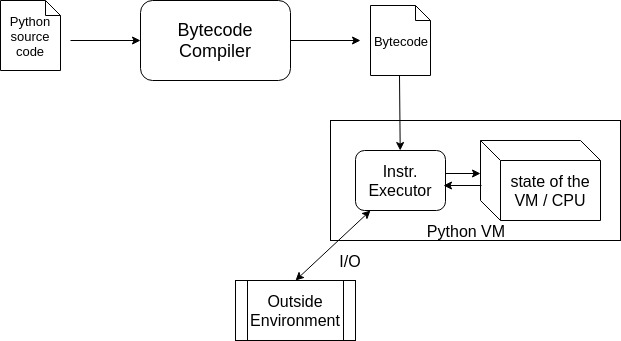